# The NCAA's Next Super Star


![alt text][all_star_game_2016]
## Abstract
All NCAA players have their own potential to be the next NBA superstar. No matter it started with a [terrible debut year (eg. Lebron James)](http://www.thesportster.com/basketball/15-nba-superstars-who-were-terrible-in-their-debut-season/) or rewarding one like being selected to the [all-star game (eg. Tim Duncan)](http://www.nba-allstar.com/players/lists/all-star-game-rookies.htm), it is believed that there exists some evidences in their college years foretelling their future success.

In this project, we are interested in discovering the intrinsic relationship between a player’s NCAA statistics and the presence in the NBA all-star game from a scout’s perspective. To discover this relationship, we used NCAA historical statistics from 2001 to 2016, specificly the on-court stats such as average scoring/assists/steals/rebounds/blocks. Several machine learning algorithms have been adopted on modeling this relationship.

Given players’ historical NCAA statistics, we would like to predict whether he will be a successful NBA player, which is defined by the appearance in the NBA all star game.

## Objective
Judging from indicators of each player’s NCAA statistics, we would like to predict the likelihood of a player becoming a NBA superstar in his future. 

[all_star_game_2016]: http://i.cdn.turner.com/nba/nba/dam/assets/160121164737-all-star-starters-graphic-1280-012116.1200x672.jpg "All Star Game 2016"


## Data Scraping

We investigated the [NCAA historical statistics](http://www.espn.com/nba/statistics/player/_/stat/), and discovered that most data was represented in a similar pattern. We wrote a data scraper for NCAA websites to crawl the on-court stats of the top 100 players in each category, including average scoring/assists/steals/rebounds/blocks per game and the team played for. For more details of NCAA data scraper, please check our `ESPN_NCAA_stats.py` in the attachment.

The preliminary data from the NCAA website includes features at our point of interest. However, we need labels of our data for supervised learning. A player is labeled as true if he has ever attended NBA all-star game during his career, and false if otherwise. Hence, labels of players are generated according to the wiki page [List of NBA All-Stars](https://en.wikipedia.org/wiki/List_of_NBA_All-Stars).

## Data Pre-processing
We obtained the top 100 players in different categories (average scoring/assists/steals/rebounds/blocks per game) from 2001 to 2016. To merge all the above data, we performed the following steps:

* We joined all data by indexing with player names.
* If there exists duplicate players, we removed duplicates by replacing its values with mean.
* If there is a missing value in one row, we fill NaN with zeros, standing for no records. 
* Categorical data such as TEAM are handled by using get_dummies functions.
* We seperated data into training, and testing set. All star players are split into both sets by half and half.

The table below summarizes all features used in our prediction models:



| Features  | Description  |
|   ---   |     ---           |
|  PLAYER    | Player's Name |
|  TEAM    | Player's Team |
|  MPG    | Minutes Per Game  |
|  RK_SCO    |  Rank in the Top 100 Score List  |
|  PTS | Avearage Points per Game  |
|  FGA    |  Field Goal Attempt |
|  3PA    |  Three Points Attempt |
|  FTA    |  Free Throw Attempt |
|  FG% | Field Goal Percentage  |
|  3P% | Three Points Percentage  |
|  FT% | Free Throw Percentage  |
|  RK_AST | Rank in the Top 100 Assist List  |
|  AP40M  | Assist Per 40 Minutes  |
|  RK_STL | Rank in the Top 100 Steal List |
|  STP40M | Steal Per 40 Minutes  |
|  RK_BLK | Rank in the Top 100 Blcok List  |
|  BLKP40M | Block Per 40 Minutes  |
|  RK_REB    | Rank in the Top 100 Rebound List |
|  RP40    |  Rebound Per 40 Minutes |
|  ORPG    |  Offensive Rebound Per Game |
|  DRPG    |  Deffensive Rebound Per Game |
|  TOPG   | Turnover Per Game  |
|  PF     | Personal Faul  |
|  GP     | Games Played per Season  |
|All the other| Categorical Label of Team|

## Import Libraries

Panda, sklearn, and matplotlib are heavily used in this tutorial.

 - Panda (panel data) is a Python data analysis library that makes data manipulation and analysis more easily. It provides data structures and operations for playing around numerical tables and time series.

 - Scikit-learn provides simple and efficent tools for data mining and analysis. Some highlights for tools are classification, regression, clustering, dimensionality reduction and feature selection.
 - Itertools provides some useful functions to traverse through the elements under different scenario such combinations and permutations. We mainly use combinations here to try out different feature set during feature selection.

 - Matplotlib is a 2D plotting library that offers object-oriented API to visualize numerical result.

In a nut shell, the above three libraries are specific for data anaylysis, making prediction, feature selection and data visualization respectively.

In [1]:
from urllib import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Tools
For data modeling purposes, here are some useful tools that greatly facilitates our data preparation. As a function wrapper, the dataGenerator split the dataset into training and testing ones according to the cutoff number specified.

### Data spliting
As a detail look at our data spliting, dataset are firstly permuted rowwise, then only the last cutoff number are kept in training set, whereas the rest are thrown into testing set.

In [2]:
def splitPermuteByNumber(X, y, cutoff):
    t_ind = X.index
    t_ind_perm = np.random.permutation(len(t_ind))
    perm = t_ind[t_ind_perm]

    ind = t_ind[t_ind_perm]
    t_ind_te = perm[:cutoff]
    t_ind_tr = perm[cutoff:]
    return X.loc[t_ind_te], X.loc[t_ind_tr], y.loc[t_ind_te], y.loc[t_ind_tr]

def splitPermuteByPercent(X, y, percent):
    cutoff = int(len(X) * percent)
    return splitPermuteByNumber(X, cutoff)

def dataGenerator(X_T, X_F, y_T, y_F):
    Xt_te, Xt_tr, yt_te, yt_tr = splitPermuteByNumber(X_T, y_T, 20)
    Xf_te, Xf_tr, yf_te, yf_tr = splitPermuteByNumber(X_F, y_F, 20)

    X_traning_list = ([Xt_tr] * 1 + [Xf_tr])
    y_traning_list = ([yt_tr] * 1 + [yf_tr])

    X_te = pd.concat([Xt_te, Xf_te])
    X_tr = pd.concat(X_traning_list)
    y_te = pd.concat([yt_te, yf_te])
    y_tr = pd.concat(y_traning_list)
    return X_te, X_tr, y_te, y_tr

### Measurement
Since there exists an unbalnace distribution of data label as true (players being selected to the NBA all-star) and false, the simple measurement for accuracy of the classfication result is just not good enough. Therefore, we select the area under receiver operating characteristic (ROC) and area under precision recall curves as the measurement of our result. Noted that
1. The maximum among for both of area under curve would be 1.0
2. When the ROC curves shows an diagnal line with slope 1.0 in the graph, the result is just like random guessing

The function is implemented as follows.

In [3]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

def showROCCurve(y_te, y_pred, subfig = None):
    precision, recall, threshold = precision_recall_curve(y_te, y_pred)
    average_precision = average_precision_score(y_te, y_pred)
        
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    roc_auc = auc(fpr, tpr)

    lw = 2
    if subfig:
        subfig.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)    
        subfig.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall curve (AUC = %0.2f)' % average_precision)
        subfig.legend(loc="lower right")
    return roc_auc, average_precision


## Load data

As introduced the the prior sections, tools for data processing and spliting come into use here to construct training and testing sets. Now, we have everything to play around different machine learning algorithms.

In [4]:
# NCAA with all-star true/false labels
Data_T = pd.read_csv("ncaa_allstar_data_T.csv")
Data_F = pd.read_csv("ncaa_allstar_data_F.csv")
#print 'True: ', Data_T.shape, 'False: ', Data_F.shape

# Join both true/false data to create feature set
df_all = pd.concat([Data_T, Data_F], axis=0)
df_all_team = pd.get_dummies(df_all['TEAM'])
df_all = pd.concat([df_all, df_all_team], axis=1, join_axes=[df_all.index])
df_all.drop(['PLAYER', 'allstar', 'TEAM', 'Unnamed: 0'], axis = 1, inplace = True)
feature_cols = df_all.columns

# Split true/false feature set and lable
X_T = df_all.iloc[:Data_T.shape[0]]
X_F = df_all.iloc[Data_T.shape[0]:]
y_T = Data_T['allstar']
y_F = Data_F['allstar']

## Put all the things together

With the data and the measurement ready, what we actually need is actually the learning/classificaion pipeline. Here, we try several algortihms we learnt from the class.

1	Linear Discriminant Analysis	0.60	0.80
2	Linear Regression           	0.75	0.79
3	Statistic Gradient Descent  	0.55	0.78
4	Support Vector Regression   	0.65	0.70
5	Decision Tree Regressor     	0.55	0.78
6	Bayesian Ridge              	0.66	0.68
7	Extra Trees Classifier      	0.50	0.75
8	Gradient Boosting Regressor 	0.85	0.88


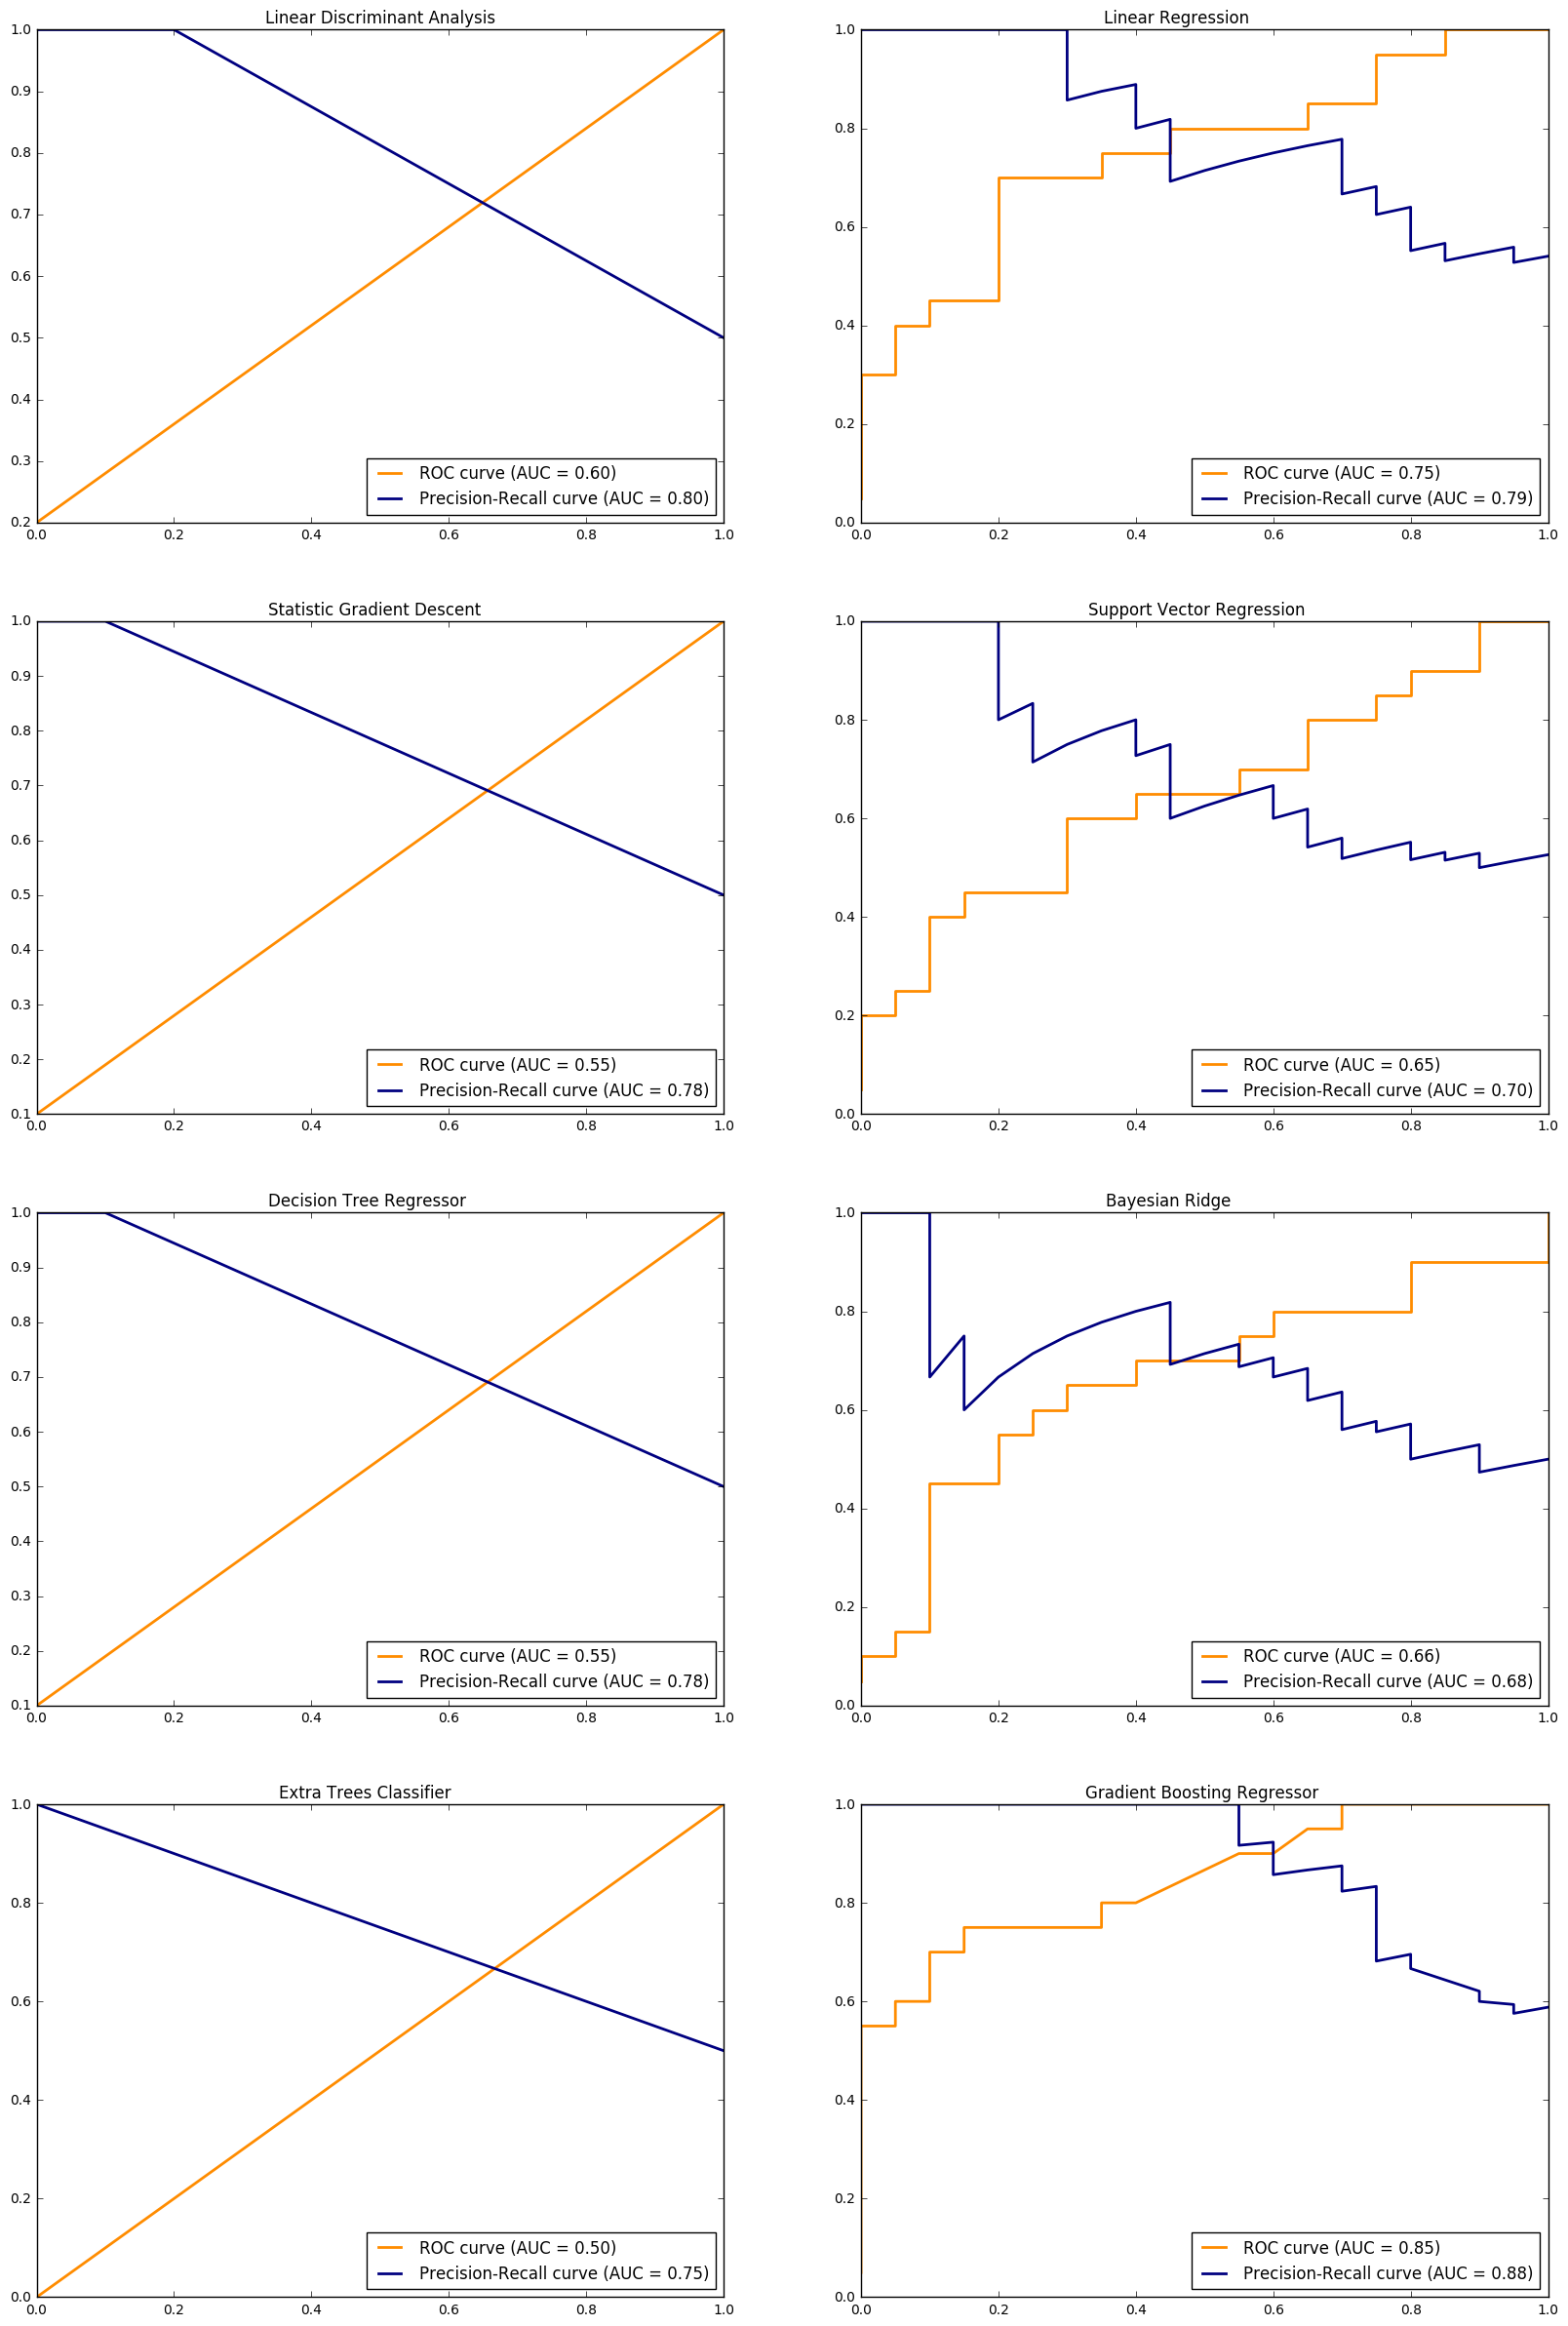

In [14]:
import time

from sklearn import linear_model
LR = linear_model.LinearRegression()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

# ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
from sklearn import svm
from sklearn.svm import NuSVR
SVR = svm.SVR()

from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, n_iter=50, l1_ratio=0.2)

# ref: http://scikit-learn.org/stable/modules/tree.html#regression
from sklearn import tree
DTR = tree.DecisionTreeRegressor()

# ref: http://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html
BR = linear_model.BayesianRidge()


from sklearn.ensemble import ExtraTreesClassifier
ETC = ExtraTreesClassifier(n_estimators=250, random_state=0)

# ref = http://scikit-learn.org/stable/modules/ensemble.html#regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')



X_te, X_tr, y_te, y_tr = dataGenerator(X_T, X_F, y_T, y_F)

fig = plt.figure(figsize=(20, 30))
count = 0
for model, name in zip([LDA, LR, SGD, SVR, DTR, BR, ETC, GBR], 
                       ["Linear Discriminant Analysis", 
                        "Linear Regression           ",
                        "Statistic Gradient Descent  ", 
                        "Support Vector Regression   ",
                        "Decision Tree Regressor     ", 
                        "Bayesian Ridge              ", 
                        "Extra Trees Classifier      ", 
                        "Gradient Boosting Regressor "]):
    y_pred = model.fit(X_tr, y_tr).predict(X_te)
    count += 1
    sub = fig.add_subplot(4, 2, count)
    sub.set_title(name)    
    auc_roc, auc_prc = showROCCurve(y_te, y_pred, sub)
    print "%d\t%s\t%.2f\t%.2f" % (count, name, auc_roc, auc_prc)
    
plt.show()    

### Neural network
Except for the model that can easily derive, we also tried to build our own neural network, and forming the binary classifier as the homeworks suggests. From all the optimizer we can choose, we left four that shows best result experimentally.

In [15]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
def predict_from_features(X, y, X_te, lossfnc = 'binary_crossentropy', optmizerName = 'rmsprop', epoch = 20):
    """ Given labels and VGG features, predict the breed of the testing set. 
    Args: 
        X (numpy ndarray) : 2D array of VGG features, each row is a set of features for a single example
        y (numpy ndarray) : 1D array of labels corresponding to the features in X
        X_te (numpy ndarray) : 2D array of VGG features for unlabeled examples
    Returns: 
        (numpy ndarray) 1D array of predicted labels for the unlabeled examples in X_te
    """

    X, y, X_te = X.as_matrix(), y.as_matrix(), X_te.as_matrix()
    m, n = X.shape
    model = Sequential()
    model.add(Dense(1024, input_dim=n, init='uniform'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, init='normal', activation='sigmoid'))

    model.compile(loss = lossfnc,
                  optimizer = optmizerName,
                  metrics = ['accuracy'])
    
    model.fit(X, y, batch_size=32, nb_epoch=epoch, verbose=0)
    y_p = model.predict(X_te)
    
    return y_p

Using Theano backend.


1 sgd
2 Adam
3 Adamax
4 RMSprop


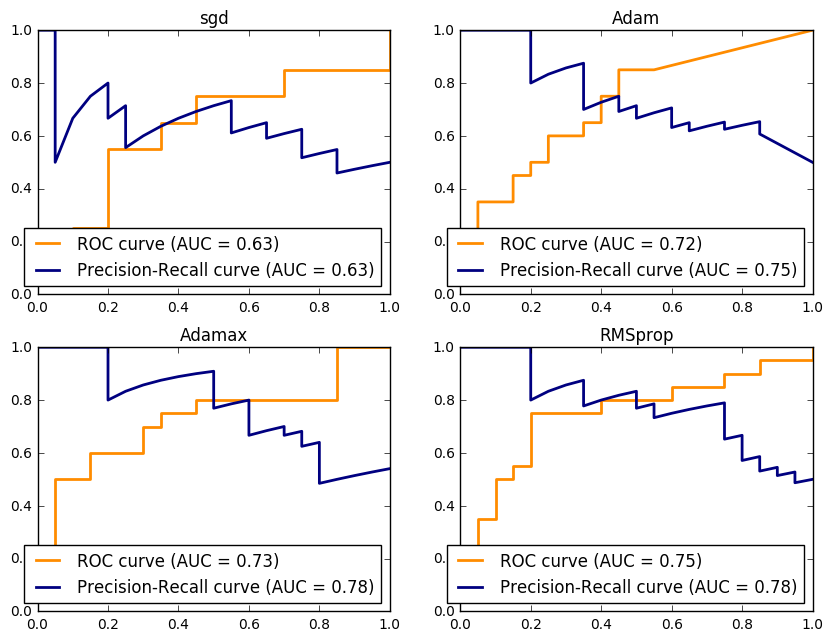

In [16]:
fig.clf()
fig = plt.figure(figsize=(10, 7.5))
count = 0
for opter in ["sgd", "Adam", "Adamax", "RMSprop"]:    
    y_pred = predict_from_features(X_tr, y_tr, X_te, epoch=5, optmizerName = opter)
    count += 1
    sub = fig.add_subplot(2, 2, count)
    sub.set_title(opter)
    print count, opter
    showROCCurve(y_te, y_pred, sub)
plt.show()    

## Feature importance

For more details of how we derived each model, please check our training codes above. 

We use area under precision-recall curve (AUC) to evaluate their performances. Among all models, gradient boosting regressor performs best. We use its attribute feature_importances to get important scores of each dimension. Based on the important scores, we can select dimensions that are greater than mean of all important scores.

In [17]:
feature_names = X_te.columns
importances =  GBR.feature_importances_
important_axis = [(importances[i], feature_names[i]) 
                  for i in range(len(importances)) if importances[i] > np.mean(importances)]

for weight, name in sorted(important_axis, reverse = True)[:10]:
    print "{}\t{}\n".format(weight, name)
    
important_names = feature_names[importances > np.mean(importances)]
print "Selected features:", important_names
print "========="
print "Deleted features:", set(X_te.columns) - set(important_names)

0.138	FGA

0.126	FG%

0.12	RP40

0.112	ORPG

0.044	RK_AST

0.032	RK_REB

0.028	FLA

0.026	WAKE

0.026	DRPG

0.024	PF

Selected features: Index([u'GP', u'TOPG', u'RK_AST', u'PF', u'RK_BLK', u'PTS', u'FG%', u'3P%',
       u'FT%', u'RK_SCO', u'FGA', u'FTA', u'ORPG', u'DRPG', u'RP40', u'RK_REB',
       u'ARIZ', u'CONN', u'CREI', u'DAV', u'FLA', u'FRES', u'GT', u'MARQ',
       u'MSU', u'OKLA', u'TEX', u'TLSA', u'UCLA', u'UK', u'UNM', u'WAKE',
       u'WASH', u'WSU', u'XAV'],
      dtype='object')
Deleted features: set(['CLMB', 'GRAM', 'ISU', 'UNLV', 'SIU', 'PRIN', 'MIA', 'CLEV', 'SJSU', 'SHSU', 'DEL', 'MIZ', 'LIP', 'BUT', 'SIE', 'CLEM', 'UTEP', 'NDSU', 'FAU', 'ODU', 'UCRV', 'RAD', 'IPFW', 'HAMP', 'SAM', 'SAC', 'MONM', 'SPU', 'LONG', 'ARPB', 'MONT', 'UCD', 'IDHO', 'YALE', 'OHIO', 'SOU', 'RID', 'UAB', 'MSST', 'NCAT', 'RK_STL', 'GW', 'DREX', 'HC', 'VAN', 'GTWN', 'FIU', 'OAK', 'UPST', 'CCAR', 'URI', 'DUQ', 'NMSU', 'ALBY', 'CHS', 'EVAN', 'GB', 'UVA', 'NAVY', 'MURR', 'VALP', 'HARV', 'JAC', 'HAW',

## Hypothesis testing

So another interesting problem is that, if we use the selected features only and train the model again, will it perform better? We applied hypothesis testing on our hypothesis: using selected features, models should have higher mean of area under curve than the original one. If the resulting P-value is less than (or equal to) 1%, we can reject the null hypothesis in favor of our hypothesis. 

Our one time experiment set up is as follows:
(1) We perform a random spliting on the original dataset.
(2) We then test each model on using the original features as well as the selected features.
(3) We gather the ROC value for the prediction result.

After one hundreads run of the experiment, we perform T-test for the means of two independence samples of AUC value. 

In [19]:
def featureSelection(X_tr, X_te, important_names):
    Xsub_tr = pd.DataFrame()
    Xsub_te = pd.DataFrame()
    for name in important_names:
        Xsub_tr = pd.concat([Xsub_tr, X_tr[name]], axis=1)
        Xsub_te = pd.concat([Xsub_te, X_te[name]], axis=1)
    return Xsub_tr, Xsub_te


from scipy import stats

bestModels = []
for model, name in zip([LR, SVR, BR, GBR],
                   ["Linear Regression", "Support Vector Regression",
                    "Bayesian Ridge", "Gradient Boosting Regressor"]):
    originalFeatureAUC = []
    featureSelctionAUC = []
    bestModel, bestVal = None, 0.0
    for i in range(100):  
        X_te, X_tr, y_te, y_tr = dataGenerator(X_T, X_F, y_T, y_F)    
        Xsub_tr, Xsub_te = featureSelection(X_tr, X_te, important_names)        

        y_predOri = model.fit(X_tr, y_tr).predict(X_te)
        y_predSel = model.fit(Xsub_tr, y_tr).predict(Xsub_te)

        ori_roc_auc, ori_prc_auc = showROCCurve(y_te, y_predOri)
        sel_roc_auc, sel_prc_auc = showROCCurve(y_te, y_predSel)
        originalFeatureAUC.append(ori_prc_auc)
        featureSelctionAUC.append(sel_prc_auc)
        if sel_prc_auc > bestVal:
            bestVal = sel_prc_auc
            bestModel = model
    bestModels += [bestModel]
            
        
    npOri, npFea = np.asarray(originalFeatureAUC), np.asarray(featureSelctionAUC)
    t, p = stats.ttest_ind(npOri, npFea)
    print "using model:", name
    print "mean of AUC using original features", npOri.mean()
    print "mean of AUC using selected features", npFea.mean()
    print "p value of the two models", p
    print "===="

using model: Linear Regression
mean of AUC using original features 0.750083325866
mean of AUC using selected features 0.78437754379
p value of the two models 0.00226320307403
====
using model: Support Vector Regression
mean of AUC using original features 0.610186531155
mean of AUC using selected features 0.70869606626
p value of the two models 3.96080937534e-15
====
using model: Bayesian Ridge
mean of AUC using original features 0.74197134688
mean of AUC using selected features 0.788798025164
p value of the two models 6.81620881295e-06
====
using model: Gradient Boosting Regressor
mean of AUC using original features 0.765307895429
mean of AUC using selected features 0.786731831041
p value of the two models 0.048911937576
====


## Conclusion

Based on the feature importance scores from gradient boosting regressor, we performed features selection. We evaluated the p-values against the null hypothesis, that is, the mean of AUC between the original features and selected features are the same. It is observed that after our feature selection process, there is a significant improvement on all the models. We suspect the reason to be as follows:

(1) In the original feature spaces, the categorical information of each team is too sparse, which increases the difficulty for the models to fit the data.  For example, some low-ranking universities are considered less representative than those high-ranking ones.

(2) We observed that block per 40 minutes (BLKP40) and 3 points attempt (3PA) are not selected to be the final features. We suspect that these two data are too positional specific. Particularly, guards have near zero values in BLKP40, whereas forwards/centers have almost no 3PA in average. This characteristic makes the general models harder to fit in for players in both positions.

### So... who's the next superstar in NCAA 2016?
In the above analysis, we studied the performance of different models to predict the next superstar to participate in the all-star games, and verified that Gradient Boosting Regression Tree (GBRT) scores the highest accuracy among all. Thus, as a final investigation in this project, by using the best model obtained so far, we provide the forecast of the next superstars in NCAA as a closing note.


In [20]:
# Team get dummies
def getTeamDummy(row):
    row[row['TEAM']] = 1
    return row

# Generate featureset for the input dataframe
def getFeatures(fname, f_cols):
    # Read 2016 ncaa stats
    data_2016 = pd.read_csv(fname)
    f_cols = list(f_cols)
    for c in f_cols:
        if c not in data_2016.columns:
            data_2016[c] = 0

    # Get team dummies and generate feature set
    X_p = data_2016.apply(getTeamDummy, axis = 1)
    return data_2016, X_p[f_cols]

# Predict
data_2016, X_p = getFeatures("ncaa_allstar_2016_data_F.csv", feature_cols)


Xsub_p = pd.DataFrame()
for name in important_names:
    Xsub_p = pd.concat([Xsub_p, X_p[name]], axis=1)
    

names_2016 = data_2016['PLAYER']
y_pred = bestModels[-1].predict(Xsub_p)
stars = zip(y_pred, names_2016)
stars.sort(reverse = True)
stars[:7]

[(0.75256216317130797, 'Tim Williams'),
 (0.70154470468343799, 'Dedric Lawson'),
 (0.68492190924187824, 'Jimmy Hall'),
 (0.66404883147105742, 'Jaylen Johnson'),
 (0.66404883147105742, 'Javis Howard'),
 (0.66404883147105742, 'Jalen Jenkins'),
 (0.1946060465589389, 'Markelle Fultz')]

## Results

According to the prediction results from the Gradient Boosting Regressor (GBR), we listed the top 7 future NBA stars in the below tables. The result reflects their on-court stats in this season, which they have played 4-5 games so far.

| Rank        | Name           | Profile       | Scout Grade (ESPN)     |
|:-------------:|:-------------:|:-----:|:-----:|
| 1      | [Tim Williams](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/147370/tim-williams) | ![alt text][Tim Williams] | 87 |
| 2      | [Dedric Lawson](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/171068/dedric-lawson) | ![alt text][Dedric Lawson] | 89 |
| 3      | [Jimmy Hall](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/140227/jimmy-hall) | ![alt text][Jimmy Hall] | 84 |
| 4      | [Jaylen Johnson](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/207403/jalen-johnson) | ![alt text][Jaylen Johnson] | 81 |
| 5      | [Javis Howard](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/187931/javis-howard) | ![alt text][Javis Howard] | NA |
| 6      | [Jalen Jenkins](http://www.espn.com/mens-college-basketball/player/_/id/62812/jalen-jenkins) | ![alt text][Jalen Jenkins] | NA |
| 7      | [Markelle Fultz](http://www.espn.com/college-sports/basketball/recruiting/player/_/id/203881/markelle-fultz) | ![alt text][Markelle Fultz] | 96 |

[Tim Williams]: http://golobos.com/images/2016/9/8/Williams1.jpg?width=182&height=250&scale=both&bgcolor=c61e3a "Markelle Fultz"
[Jimmy Hall]: http://a.espncdn.com/combiner/i?img=/i/headshots/recruiting/ncb/players/190/140227.jpg&w=190&h=254 "Jimmy Hall"
[Dedric Lawson]: http://a.espncdn.com/combiner/i?img=/i/headshots/recruiting/ncb/players/full/171068.png&w=350&h=254 "Dedric Lawson"
[Jaylen Johnson]: https://s3media.247sports.com/Uploads/Assets/877/615/4_4615877.jpg "Jaylen Johnson"
[Javis Howard]: http://a.espncdn.com/combiner/i?img=/i/headshots/recruiting/ncb/players/190/187931.jpg&w=190&h=254 "Javis Howard"
[Jalen Jenkins]: http://www.gomason.com/images/2016/9/23/WYLLRYZPVQNONYW.20160923125952.jpg?width=300 "Jalen Jenkins"
[Markelle Fultz]: http://a.espncdn.com/combiner/i?img=/i/headshots/recruiting/ncb/players/full/203881.png&w=350&h=254 "Markelle Fultz"

## References

In this project, we explored many python libraries that come in handy when working on data processing, visualization and modeling. Following are some more details as points of reference.

- Pandas: http://pandas.pydata.org/
- Matplotlib: http://matplotlib.org/
- Scikit-learn: http://scikit-learn.org/
- Linear Models in Scikit-learn: http://scikit-learn.org/stable/modules/linear_model.html